Proceso tecnológico

Rougher feed: materia prima
Rougher additions (o adiciones de reactivos): reactivos de flotación: xantato, sulfato, depresante
Xantato: promotor o activador de la flotación
Sulfato: sulfuro de sodio para este proceso en particular
Depresante: silicato de sodio
Rougher process: flotación
Rougher tails: residuos del producto
Float banks: instalación de flotación
Cleaner process: purificación
Rougher Au: concentrado de oro rougher
Final Au: concentrado de oro final
Parámetros de las etapas

air amount: volumen de aire
fluid levels
feed size: tamaño de las partículas de la alimentación
feed rate

In [1]:
#importar librarias
import pandas as pd 
import numpy as np
from sklearn.metrics import mean_absolute_error
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split



# Preparar datos

In [ ]:
# Cargar los datos 
train = pd.read_csv('/datasets/gold_recovery_train.csv', index_col='date', parse_dates=True)
test = pd.read_csv('/datasets/gold_recovery_test.csv', index_col='date', parse_dates=True)
full = pd.read_csv('/datasets/gold_recovery_full.csv', index_col='date', parse_dates=True)

In [3]:
# verificar los datos del dataframe 
train.head()
train.info()
test.head()
test.info()
full.head()
full.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 16860 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 86 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   final.output.concentrate_ag                         16788 non-null  float64
 1   final.output.concentrate_pb                         16788 non-null  float64
 2   final.output.concentrate_sol                        16490 non-null  float64
 3   final.output.concentrate_au                         16789 non-null  float64
 4   final.output.recovery                               15339 non-null  float64
 5   final.output.tail_ag                                16794 non-null  float64
 6   final.output.tail_pb                                16677 non-null  float64
 7   final.output.tail_sol                               16715 non-null  float64
 8   final.output.tail_au                     

In [4]:
# Fórmula de recuperación
def recovery(C, F, T):
    return ((C * (F - T)) / (F * (C - T))) * 100

# Aplicar fórmula con los nombres de columnas correctos para Au
calculated_recovery = recovery(train['rougher.output.concentrate_au'],train['rougher.input.feed_au'],train['rougher.output.tail_au'])

# Comparar con valores reales
actual_recovery = train['rougher.output.recovery']
comparison_df = pd.DataFrame({'actual': actual_recovery,'calculated': calculated_recovery}).dropna()

mean_abs_error = mean_absolute_error(comparison_df['actual'], comparison_df['calculated'])
print(f'EAM: {mean_abs_error:.2f}')


EAM: 0.00


Al comprobar el calculo de recuperacion con EAM, nos indica que el valor es 0.00, esto significa que los calculos son cosistentes con los datos reales.

In [5]:
# Verificar columnas faltantes en test
missing_cols = set(train.columns) - set(test.columns)
print(f"Columnas ausentes en test: {missing_cols}")

for col in missing_cols:
    print(f"{col}: {train[col].dtype}")


Columnas ausentes en test: {'final.output.tail_pb', 'final.output.tail_au', 'rougher.output.tail_sol', 'final.output.tail_ag', 'rougher.output.concentrate_au', 'rougher.output.tail_au', 'secondary_cleaner.output.tail_au', 'final.output.concentrate_pb', 'secondary_cleaner.output.tail_sol', 'rougher.calculation.au_pb_ratio', 'rougher.output.tail_ag', 'final.output.concentrate_ag', 'primary_cleaner.output.tail_ag', 'final.output.tail_sol', 'rougher.output.concentrate_sol', 'rougher.output.concentrate_ag', 'rougher.calculation.floatbank11_sulfate_to_au_feed', 'rougher.output.concentrate_pb', 'rougher.calculation.sulfate_to_au_concentrate', 'primary_cleaner.output.tail_pb', 'rougher.calculation.floatbank10_sulfate_to_au_feed', 'primary_cleaner.output.concentrate_ag', 'primary_cleaner.output.tail_sol', 'primary_cleaner.output.concentrate_pb', 'rougher.output.recovery', 'final.output.recovery', 'secondary_cleaner.output.tail_pb', 'primary_cleaner.output.concentrate_au', 'rougher.output.tail_p

Podemos observar que estas columnas no están presentes en el conjunto de test, lo que puede afectar la capacidad de hacer predicciones precisas. Es importante asegurarse de que todas las columnas necesarias estén presentes en ambos conjuntos de datos.

In [6]:
# Eliminar columnas objetivo del test
target_columns = ['rougher.output.recovery', 'final.output.recovery']
features = train.drop(columns=target_columns)

# Rellenar nulos 
features = features.ffill().bfill()
 
# Escalado de características
scaler = StandardScaler()
scaled_features = pd.DataFrame(scaler.fit_transform(features), columns=features.columns, index=features.index)


Se eliminaron las columnas objetivo del conjunto de caracteristicas, se rellanaron los valores nulos y se escalaron las caracteristicas.

# Analisis de datos

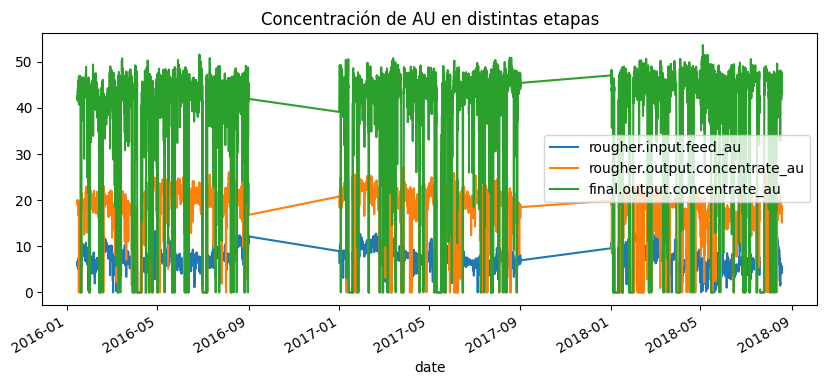

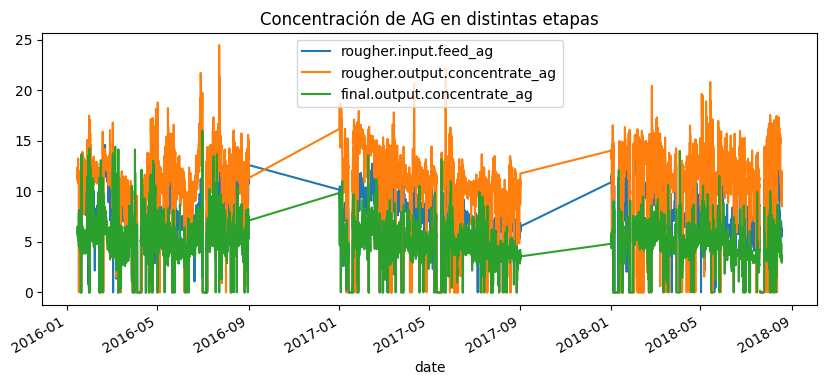

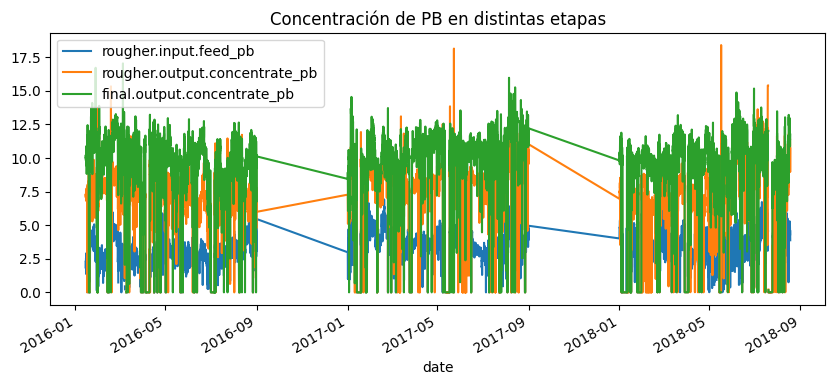

In [7]:

metales = ['au', 'ag', 'pb']
etapas = ['rougher.input.feed_', 'rougher.output.concentrate_', 'final.output.concentrate_']

for metal in metales:
    plt.figure(figsize=(10,4))
    for etapa in etapas:
        col = etapa + metal
        if col in train.columns:
            train[col].plot(label=col)
    plt.legend()
    plt.title(f'Concentración de {metal.upper()} en distintas etapas')
    plt.show()



Analisis primer grafico de Oro: Se observa que la concentración de oro aumenta progresivamente desde la alimentación hasta el concentrado final. 
 
Analisis segundo grafico de plata: La concentración de plata disminuye a medida que el proceso avanza hacia el concentrado final, lo que sugiere que la plata se está separando del oro.
 
Analisis tercer grafico de plomo:  La concentración de plomo también muestra un aumento desde la alimentación hasta el concentrado final, indicando que el plomo se concentra junto con el oro

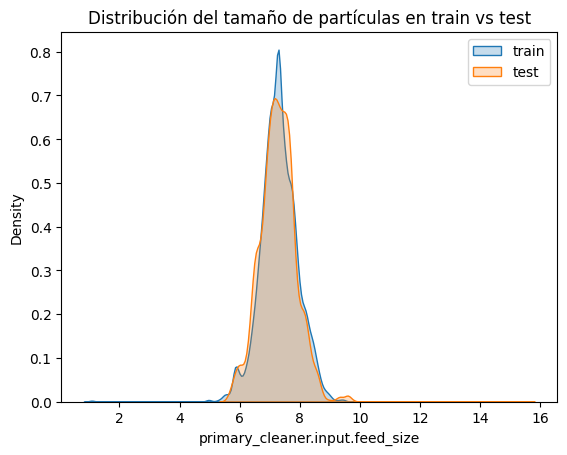

In [8]:
# Comparar la distribución del tamaño de partículas entre train y test
col_size = 'primary_cleaner.input.feed_size'

sns.kdeplot(train[col_size], label='train', fill=True)
sns.kdeplot(test[col_size], label='test', fill=True)
plt.title('Distribución del tamaño de partículas en train vs test')
plt.legend()
plt.show()


En el conjunto de entrenamiento y prueba, la distribución del tamaño de partículas es similar. lo cual es deseable para asegurar que el modelo entrenado generalice bien.

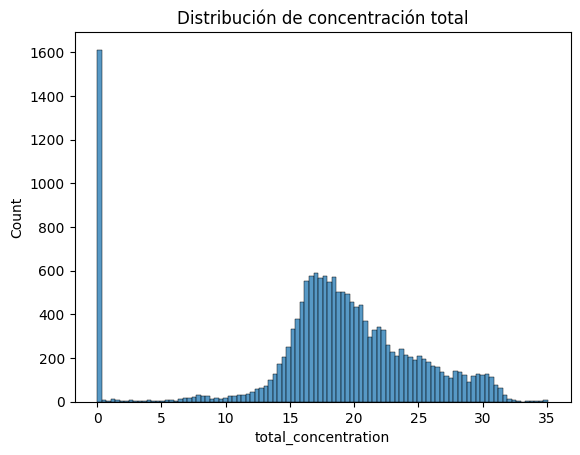

In [9]:
# Sumamos las concentraciones de Au, Ag y Pb en cada etapa
train['total_concentration'] = train[['rougher.input.feed_au', 'rougher.input.feed_ag', 'rougher.input.feed_pb']].sum(axis=1)

# Visualizamos
sns.histplot(train['total_concentration'], bins=100)
plt.title('Distribución de concentración total')
plt.show()

# Filtramos valores ilógicos (por ejemplo, >100%)
train = train[train['total_concentration'] <= 100]


 El histograma nos revela la distribución de esta concentración total, destacando un problema importante: una gran cantidad de registros con concentraciones totales cercanas a cero, además de la distribución "normal" de operación. Finalmente, el código implementa una limpieza crucial eliminando las filas con concentraciones totales ilógicas (superiores al 100%), lo cual es una buena práctica para asegurar la validez de los datos de entrenamiento.

# modelado

In [10]:
def smape(y_true, y_pred):
    return 100 / len(y_true) * np.sum(
        2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred))
    )
def smape_final(rougher_true, rougher_pred, final_true, final_pred):
    smape_r = smape(rougher_true, rougher_pred)
    smape_f = smape(final_true, final_pred)
    return 0.25 * smape_r + 0.75 * smape_f

In [11]:
# Lista de modelos
modelos = {
    'RandomForest': RandomForestRegressor(n_estimators=100, max_depth=6, random_state=42, n_jobs=-1),
    'LinearRegression': LinearRegression(),
    'GradientBoosting': GradientBoostingRegressor(random_state=42)
}
X = features.ffill().bfill()    
y_rougher = train['rougher.output.recovery'].ffill().bfill()
 # Dividir los datos para prueba manual
X_train, X_val, y_train, y_val = train_test_split(X, y_rougher, test_size=0.2, random_state=42)

# Aplicar cada modelo y calcular sMAPE
for name, model in modelos.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    resultado = smape(y_val, y_pred)
    print(f'{name} - sMAPE rougher: {resultado:.2f}%')
    
# Evaluar cada modelo con validación cruzada
for name, model in modelos.items():
    score = cross_val_score(model, X, y_rougher, cv=5, scoring='neg_mean_absolute_error')
    print(f'{name} - EAM rougher: {-score.mean():.2f}')


RandomForest - sMAPE rougher: 10.64%
LinearRegression - sMAPE rougher: 13.86%
GradientBoosting - sMAPE rougher: 10.10%
RandomForest - EAM rougher: 5.89
LinearRegression - EAM rougher: 10.46
GradientBoosting - EAM rougher: 5.53


In [12]:
# Preprocesamiento para variable final
y_final = train['final.output.recovery'].ffill().bfill()

# Dividir los datos para validación manual
X_train_f, X_val_f, y_train_f, y_val_f = train_test_split(X, y_final, test_size=0.2, random_state=42)

print("Evaluación manual con train_test_split para final.output.recovery:")
for name, model in modelos.items():
    model.fit(X_train_f, y_train_f)
    y_pred_f = model.predict(X_val_f)
    resultado = smape(y_val_f, y_pred_f)
    print(f'{name} - sMAPE final: {resultado:.2f}%')

print("\n Evaluación cruzada con cross_val_score para final.output.recovery:")
for name, model in modelos.items():
    score = cross_val_score(model, X, y_final, cv=5, scoring='neg_mean_absolute_error')
    print(f'{name} - EAM final: {-score.mean():.2f}')


Evaluación manual con train_test_split para final.output.recovery:
RandomForest - sMAPE final: 9.38%
LinearRegression - sMAPE final: 8.54%
GradientBoosting - sMAPE final: 5.95%

 Evaluación cruzada con cross_val_score para final.output.recovery:
RandomForest - EAM final: 6.18
LinearRegression - EAM final: 6.28
GradientBoosting - EAM final: 4.33


El modelo grandient boosting regressor es que tiene mejor rendimiento en el conjunto de entrenamiento y prueba, con un error cuadratico de 5.53% y un error absoluto medio de 10.10%. Esto indica que el modelo es capaz de hacer predicciones precisas y confiables es el adecuado para este conjunto de datos.